# EEEL 4220 Project

In [1]:
import cvxpy as cp
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#import cartopy.feature as cf
import matplotlib.pyplot as plt
#from geopy.geocoders import Nominatim
import time

In [2]:
#SCENARIO 1 FUNCTION
def optimize_power_system_scenario1(demand, price, g_capacity):
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country, __a) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country, __b) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    # Power flow constraints
    con_set.append(theta[0] == 0)
    con_set.extend([f[i] == (theta[from_country] - theta[to_country]) / X[i] for i, (from_country, to_country, __a) in enumerate(line_mapping)])

    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    #print("Total Generation:", total_generation)
    #print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [22]:
def optimize_power_system(demand, price, g_capacity, scenario1=False):
    if scenario1==True:
        return optimize_power_system_scenario1(demand, price, g_capacity)
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    # Power flow constraints
    con_set.append(theta[0] == 0)
    for i, (from_country, to_country, capacity) in enumerate(line_mapping):
        # Power flow equation constraint
        con_set.append(f[i] == (theta[from_country] - theta[to_country]) / X[i])
        # Capacity constraint for each line
        if scenario1 == False:
            con_set.append(cp.abs(f[i]) <= capacity)
    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    #print("Total Generation:", total_generation)
    #print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [4]:
# Country to number mapping
countries = {
    "Austria": 0, "Belgium": 1, "Bulgaria": 2, "Croatia": 3, "Czechia": 4, 
    "Denmark": 5, "Estonia": 6, "Finland": 7, "France": 8, "Germany": 9, 
    "Greece": 10, "Hungary": 11, "Ireland": 12, "Italy": 13, "Latvia": 14, 
    "Lithuania": 15, "Luxembourg": 16, "Netherlands": 17, "Poland": 18, "Portugal": 19, 
    "Romania": 20, "Slovakia": 21, "Slovenia": 22, "Spain": 23, "Sweden": 24, 
    "Norway": 25, "Switzerland": 26, "United Kingdom": 27
}

line_mapping = [
    (countries["Austria"], countries["Switzerland"], 1890),
    (countries["Austria"], countries["Germany"], 3670),
    (countries["Austria"], countries["Hungary"], 1830),
    (countries["Austria"], countries["Italy"], 260),
    (countries["Austria"], countries["Slovenia"], 1550),
    (countries["Belgium"], countries["Luxembourg"], 290),
    (countries["Belgium"], countries["United Kingdom"], 1040),
    (countries["Bulgaria"], countries["Greece"], 560),
    (countries["Czechia"], countries["Austria"], 2610),
    (countries["Czechia"], countries["Slovakia"], 2330),
    (countries["Germany"], countries["Belgium"], 0),
    (countries["Germany"], countries["Switzerland"], 5910),
    (countries["Germany"], countries["Czechia"], 2860),
    (countries["Germany"], countries["Luxembourg"], 790),
    (countries["Germany"], countries["Netherlands"], 5070),
    (countries["Germany"], countries["Norway"], 0),
    (countries["Germany"], countries["Poland"], 2030),
    (countries["Denmark"], countries["Germany"], 2240),
    (countries["Denmark"], countries["Norway"], 2350),
    (countries["Denmark"], countries["Sweden"], 2070),
    (countries["Estonia"], countries["Latvia"], 830),
    (countries["Finland"], countries["Estonia"], 1020),
    (countries["Finland"], countries["Sweden"], 2770),
    (countries["France"], countries["Belgium"], 3690),
    (countries["France"], countries["Switzerland"], 4190),
    (countries["France"], countries["Germany"], 5220),
    (countries["France"], countries["Spain"], 3640),
    (countries["France"], countries["United Kingdom"], 2040),
    (countries["Croatia"], countries["Slovenia"], 1500),
    (countries["Hungary"], countries["Croatia"], 1650),
    (countries["Hungary"], countries["Slovenia"], 0),
    (countries["Hungary"], countries["Slovakia"], 2010),
    (countries["Ireland"], countries["United Kingdom"], 530),
    (countries["Italy"], countries["Switzerland"], 4810),
    (countries["Italy"], countries["France"], 3560),
    (countries["Italy"], countries["Greece"], 510),
#   (countries["Italy"], countries["Malta"], 220),
    (countries["Italy"], countries["Slovenia"], 1680),
    (countries["Lithuania"], countries["Poland"], 490),
    (countries["Latvia"], countries["Lithuania"], 1190),
    (countries["Netherlands"], countries["Belgium"], 3610),
    (countries["Netherlands"], countries["Denmark"], 700),
    (countries["Netherlands"], countries["Norway"], 730),
    (countries["Netherlands"], countries["United Kingdom"], 1090),
    (countries["Norway"], countries["Finland"], 140),
    (countries["Czechia"], countries["Poland"], 1670),
    (countries["Portugal"], countries["Spain"], 3980),
    (countries["Romania"], countries["Bulgaria"], 1300),
    (countries["Romania"], countries["Hungary"], 870),
    (countries["Sweden"], countries["Germany"], 610),
    (countries["Sweden"], countries["Lithuania"], 730),
    (countries["Sweden"], countries["Norway"], 5460),
    (countries["Sweden"], countries["Poland"], 600),
    (countries["United Kingdom"], countries["Norway"], 0),
]

In [5]:
with open('countryData.pkl', 'rb') as f:
    data = pickle.load(f)
    
with open('aggregatedGenCapacity.pkl', 'rb') as f:
    gendata = pickle.load(f)

    
mar21data, jun21data, sep21data, dec21data = {}, {}, {}, {}
for country in countries.keys():
    if country == "Cyprus": 
        continue
    mar21data[country] = data[country][0:24]
    jun21data[country] = data[country][24:48]
    sep21data[country] = data[country][48:72]
    dec21data[country] = data[country][72:]

display(jun21data)

{'Austria':                            Day-ahead Prices    Load    Wind  Solar   Hydro  \
 2019-06-21 00:00:00+02:00             34.30  5415.0  1388.0    0.0  5203.0   
 2019-06-21 01:00:00+02:00             32.17  5084.0   952.0    0.0  4590.0   
 2019-06-21 02:00:00+02:00             31.67  4935.0  1084.0    0.0  4617.0   
 2019-06-21 03:00:00+02:00             30.80  4801.0   964.0    0.0  4577.0   
 2019-06-21 04:00:00+02:00             33.42  4790.0   964.0    0.0  4764.0   
 2019-06-21 05:00:00+02:00             34.02  5067.0   964.0    8.0  4676.0   
 2019-06-21 06:00:00+02:00             40.72  5797.0   740.0   32.0  5906.0   
 2019-06-21 07:00:00+02:00             44.10  6764.0   380.0   64.0  7472.0   
 2019-06-21 08:00:00+02:00             47.09  7254.0   244.0  100.0  7660.0   
 2019-06-21 09:00:00+02:00             44.41  7469.0   240.0  156.0  7644.0   
 2019-06-21 10:00:00+02:00             43.93  7573.0   200.0  220.0  7095.0   
 2019-06-21 11:00:00+02:00             41

In [9]:
def optimize_power_system(demand, price, g_capacity, scenario1=False):
    if scenario1==True:
        return optimize_power_system_scenario1(demand, price, g_capacity)
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    if scenario1 == False:
        con_set.append(cp.abs(f[i]) <= capacity)
    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    #print("Total Generation:", total_generation)
    #print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [169]:
def solve_and_plot_day(load_price_data, gendata, dayName, scenario1 = False):
    # Initialize a list to store bus prices for each hour
    hourly_bus_prices = []
    hourly_generation = []
    hourly_transmission = []

    for time_step in range(24):
        # Construct the price and load arrays for this time step
        P = np.array([load_price_data[country]["Day-ahead Prices"].iloc[time_step] for country in countries])
        L = np.array([load_price_data[country]["Load"].iloc[time_step] for country in countries]) 
        G = np.array([sum(list(gendata[country].values())) for country in countries]) # Unlimited Transmissions Capacity
        
        total_cost, generation_amounts, bus_prices, transmission = optimize_power_system(L, P, G, scenario1)

        # Store the bus prices for this hour
        hourly_bus_prices.append(bus_prices)
        hourly_generation.append(generation_amounts)
        hourly_transmission.append(transmission)
    # Now, hourly_bus_prices is a list where each element is the bus prices for each hour
    # Plotting the DataFrame as a line plot
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 8))
    # Generation Plot
    converted_generation = [[float(value)/1000 for value in row] for row in hourly_generation]  # CAREFUL: in GW
    df_gen = pd.DataFrame(converted_generation, columns=countries.keys())
    df_gen.plot(kind='line', ax=ax1)
    ax1.set_title(dayName + ' Hourly Generations')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Generation (GW)')
    #plt.ylim(-75, 75)
    ax1.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

    
    # Transmission plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(15, 8))
    converted_transmision = [[float(value) for value in row] for row in hourly_transmission]
    df_trans = pd.DataFrame(converted_transmision, columns = line_mapping)
    # Plotting the DataFrame as a line plot
    df_trans.plot(kind='line', ax=ax2)
    ax2.set_title(dayName + ' Hourly Transmission')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('MW')
    #plt.ylim(-75, 75)
    ax2.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 2)

    # Bus Prices plot
    fig3, ax3 = plt.subplots(1, 1, figsize=(15, 8))
    converted_prices = [[abs(value) for value in row] for row in hourly_bus_prices]     # €/MWh
    df_prices = pd.DataFrame(converted_prices, columns=countries.keys())
    df_prices.plot(kind='line', ax=ax3)
    ax3.set_title(dayName + ' Hourly Bus Prices')
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Price (€/MWh)')
    #plt.ylim(-60, -20)
    ax3.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # TOTAL GEN AND COST
    fig4, ax4 = plt.subplots(1, 1, figsize=(15, 8))
    total_cost = np.sum((df_prices*df_gen*1000), axis=1)/1e6 
    df_total_cost = pd.DataFrame(total_cost, columns=["Total Costs"])
    df_total_cost.plot(kind='line', ax=ax4, color="red")
    ax4.set_title(dayName + ' Total Costs and Generation')
    ax4.set_xlabel('Hour')
    ax4.set_ylabel('Total System Costs (million €)')
    ax4.legend(bbox_to_anchor=(0.12, 1))
    
    ax41 = ax4.twinx()
    total_gen = np.sum(df_gen, axis=1)
    df_total_gen = pd.DataFrame(total_gen, columns=["Total Generation"])
    df_total_gen.plot(kind='line', ax=ax41, color="blue")
    ax41.set_ylabel('Total System Generation (GW)')
    ax41.legend(bbox_to_anchor=(1, 1))
    
    # Displaying the plot
    # Save just the portion _inside_ the second axis's boundaries
    scenario_name = "Scenario 1" if scenario1 else "Scenario 2"
    fig1.savefig(f"{scenario_name} - {dayName} Generation", bbox_inches='tight')
    fig2.savefig(f"{scenario_name} - {dayName} Transmission", bbox_inches='tight')
    fig3.savefig(f"{scenario_name} - {dayName} Bus Prices", bbox_inches='tight')
    fig4.savefig(f"{scenario_name} - {dayName} Total Cost and Generation", bbox_inches='tight')
    plt.show()

In [29]:
def solve_and_plot_day(load_price_data, gendata, dayName, scenario1 = False):
    # Initialize a list to store bus prices for each hour
    hourly_bus_prices = []
    hourly_generation = []
    hourly_transmission = []

    for time_step in range(24):
        # Construct the price and load arrays for this time step
        P = np.array([load_price_data[country]["Day-ahead Prices"].iloc[time_step] for country in countries])
        L = np.array([load_price_data[country]["Load"].iloc[time_step] for country in countries]) 
        G = np.array([sum(list(gendata[country].values())) for country in countries]) # Unlimited Transmissions Capacity
        
        total_cost, generation_amounts, bus_prices, transmission = optimize_power_system(L, P, G, scenario1)

        # Store the bus prices for this hour
        hourly_bus_prices.append(bus_prices)
        hourly_generation.append(generation_amounts)
        hourly_transmission.append(transmission)
    # Now, hourly_bus_prices is a list where each element is the bus prices for each hour
    # Plotting the DataFrame as a line plot
    
    return P

In [28]:
P_1 = solve_and_plot_day(mar21data, gendata, 'March 21st', scenario1=True)

In [30]:
P_2 = solve_and_plot_day(mar21data, gendata, 'March 21st', scenario1=False)

In [31]:
print(P_1)
print(P_2)

[ 39.3    39.65   48.     39.3    38.19   39.28   35.23   35.23   39.36
  39.28    0.     38.19   37.44   47.245  35.23   35.23   39.28   39.09
 207.06   55.01  169.     38.19   39.3    55.01   35.23   39.36   39.79
  36.07 ]
[ 39.3    39.65   48.     39.3    38.19   39.28   35.23   35.23   39.36
  39.28    0.     38.19   37.44   47.245  35.23   35.23   39.28   39.09
 207.06   55.01  169.     38.19   39.3    55.01   35.23   39.36   39.79
  36.07 ]


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02


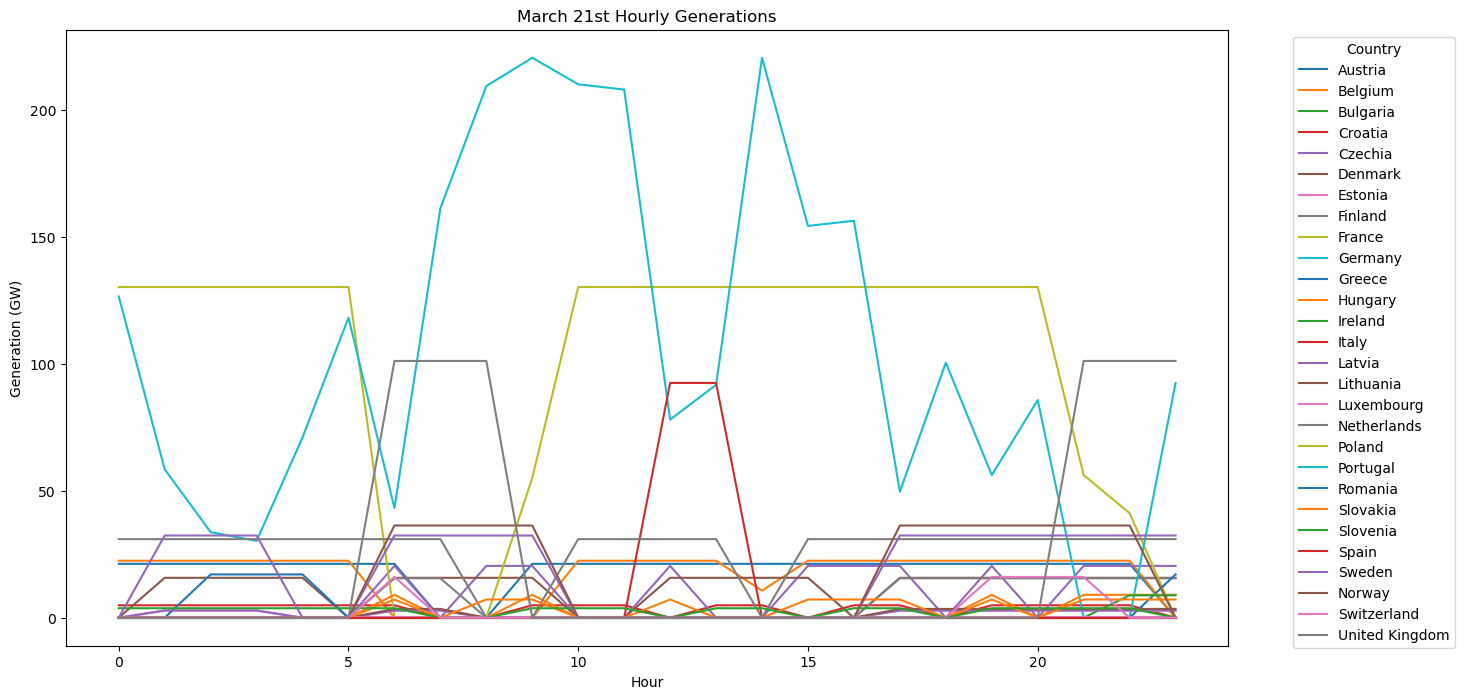

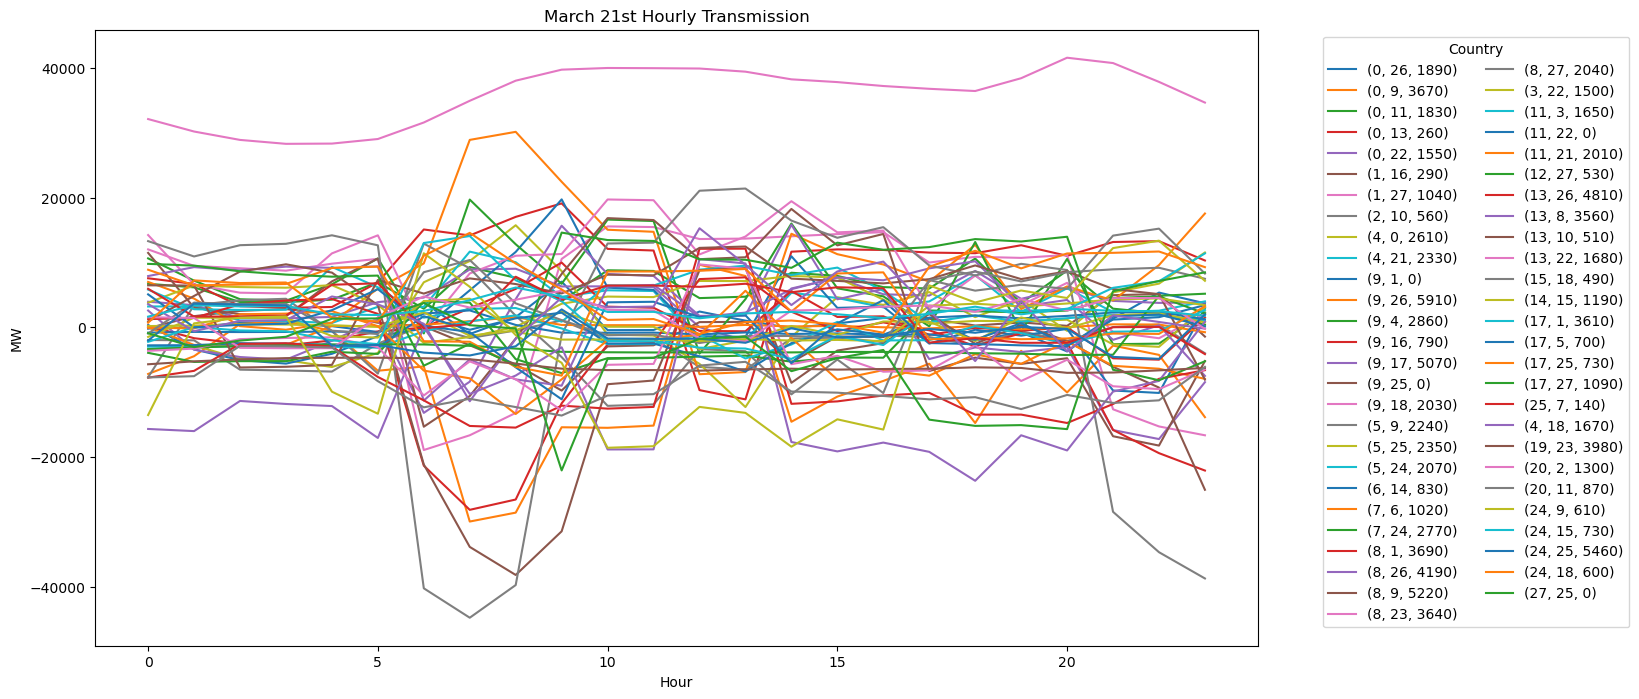

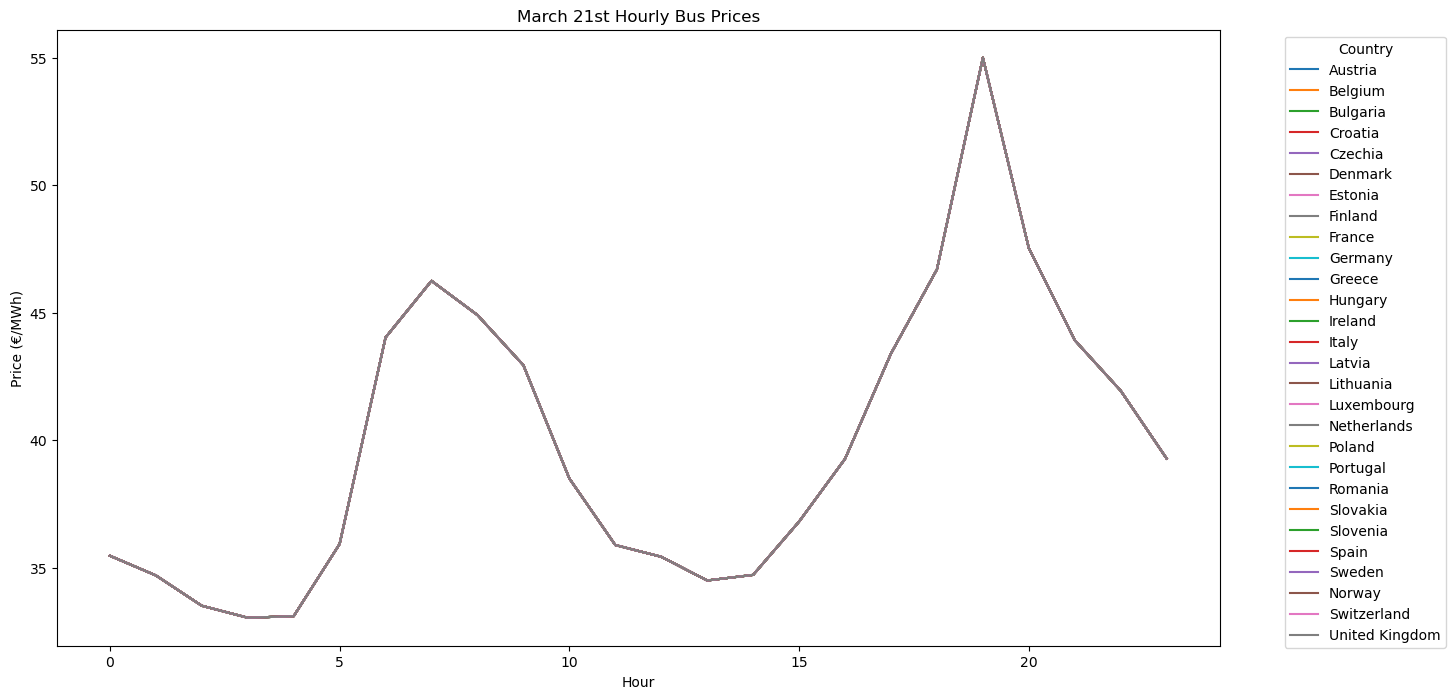

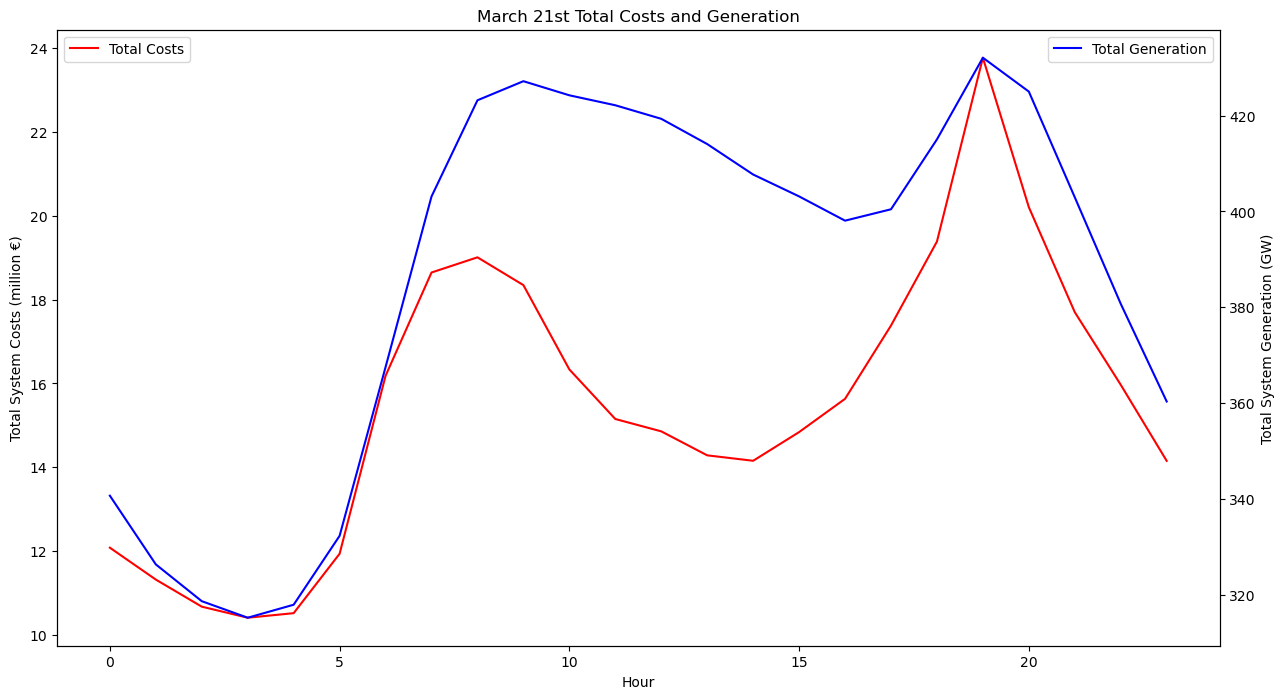

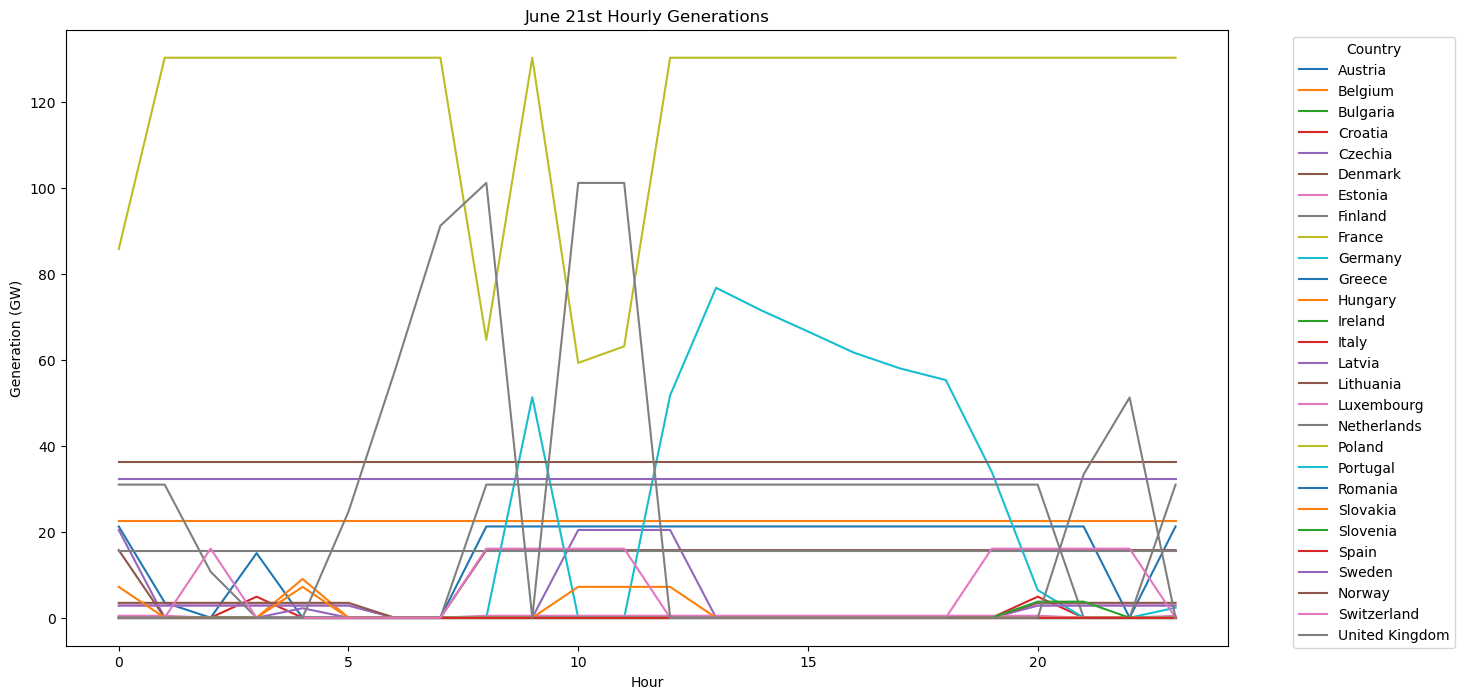

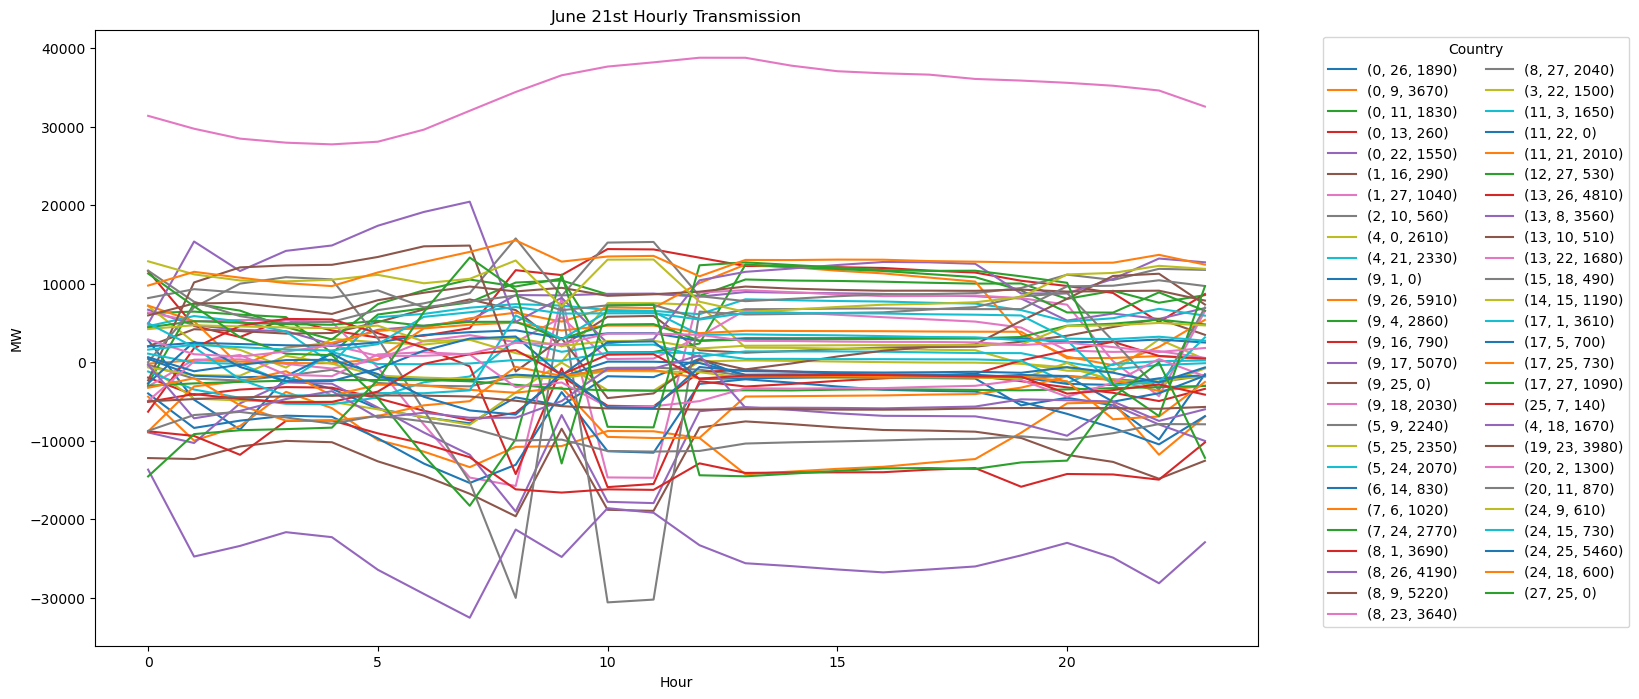

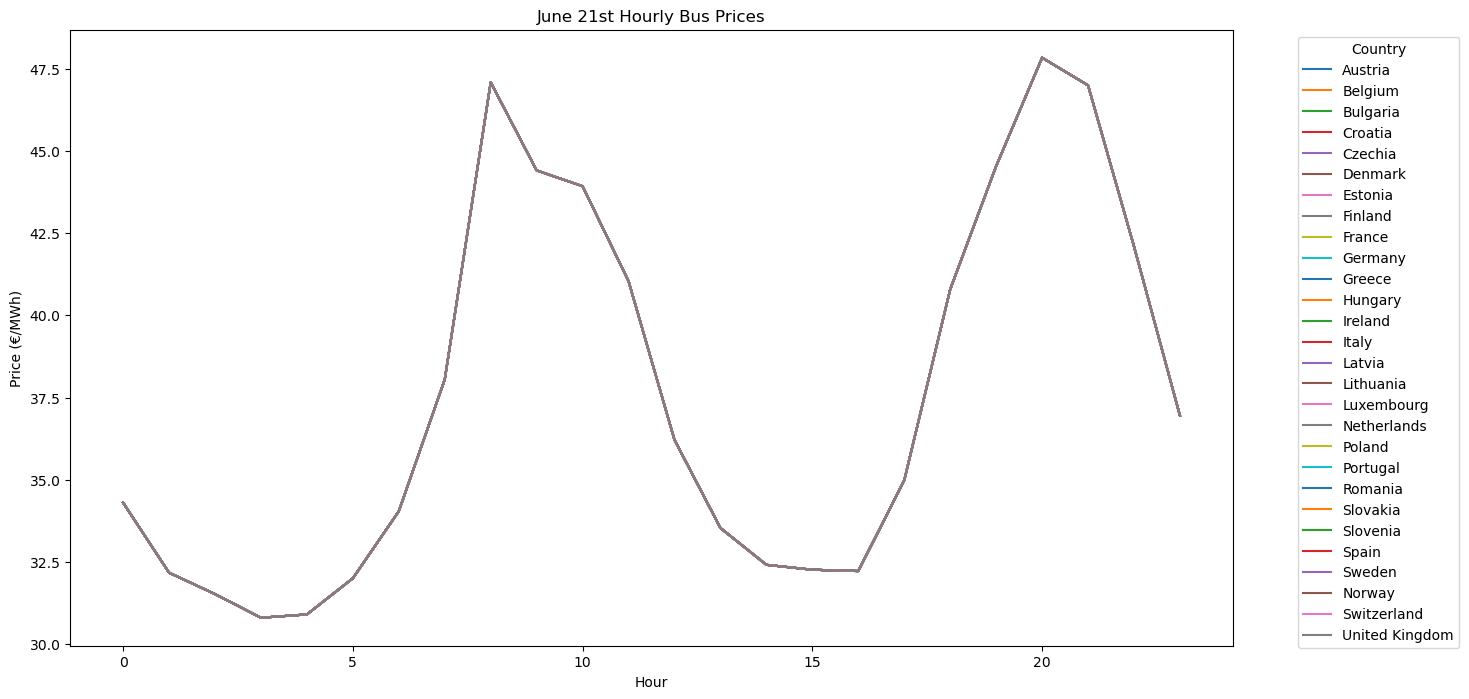

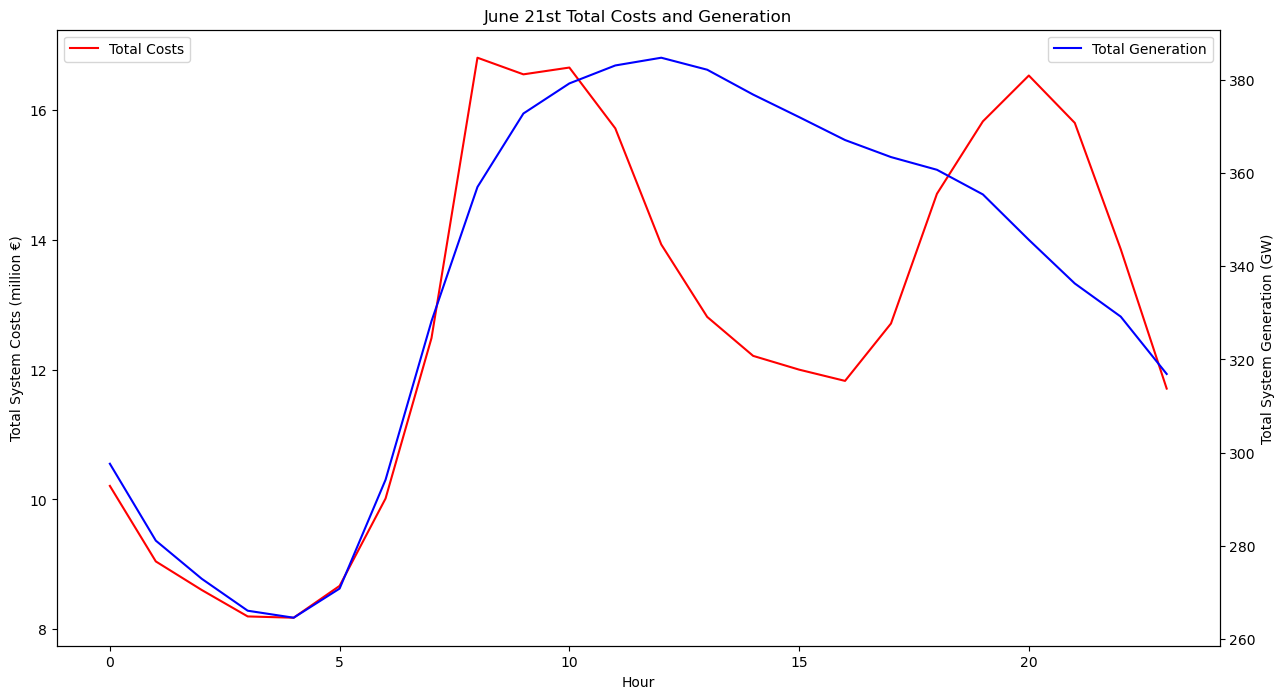

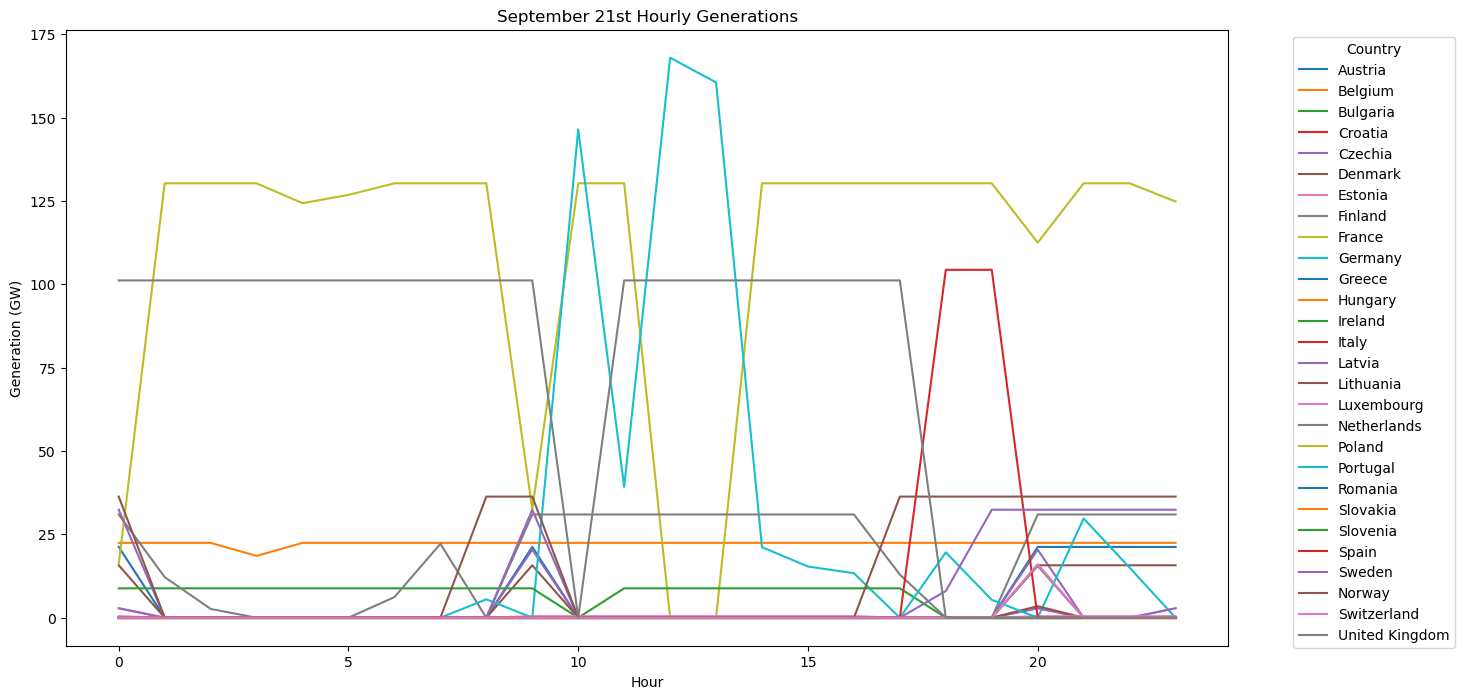

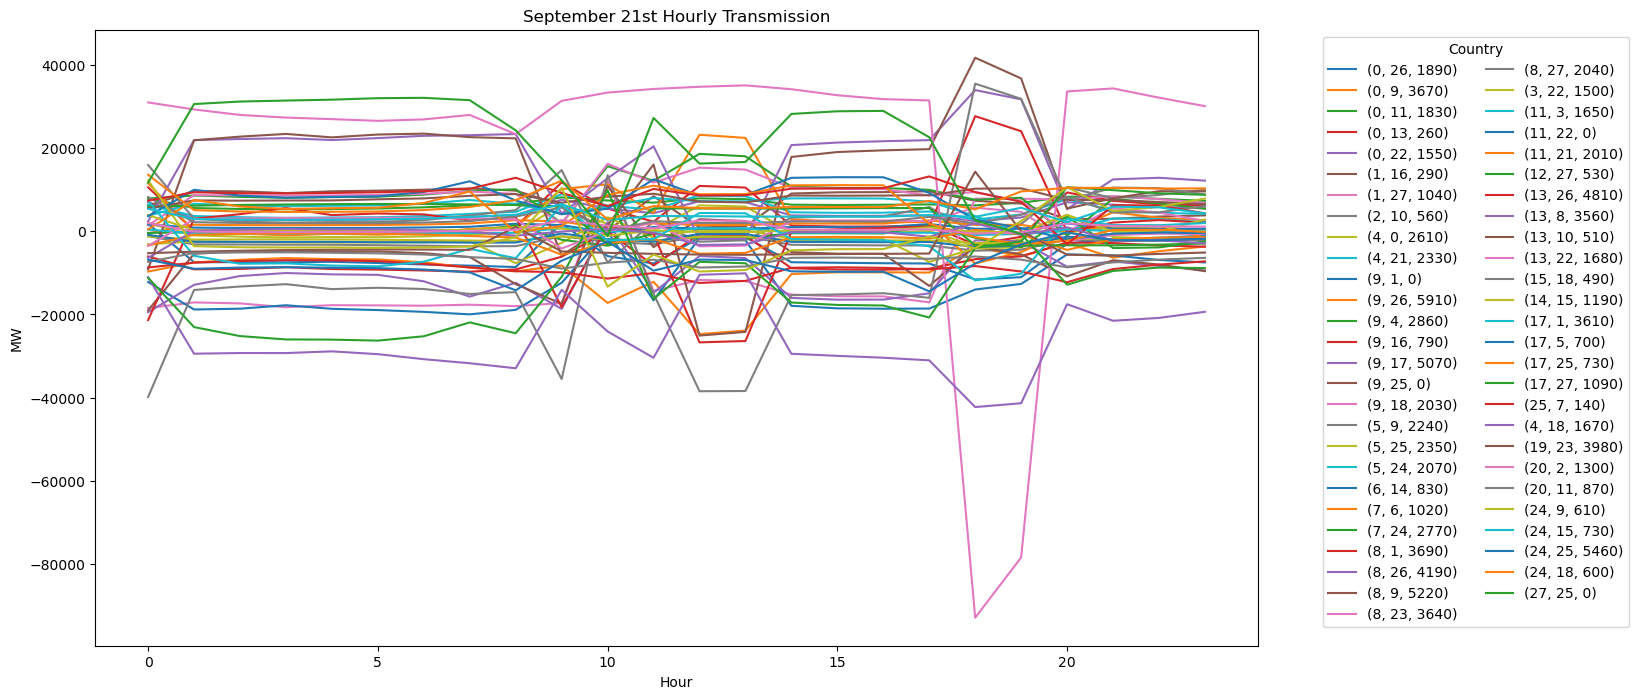

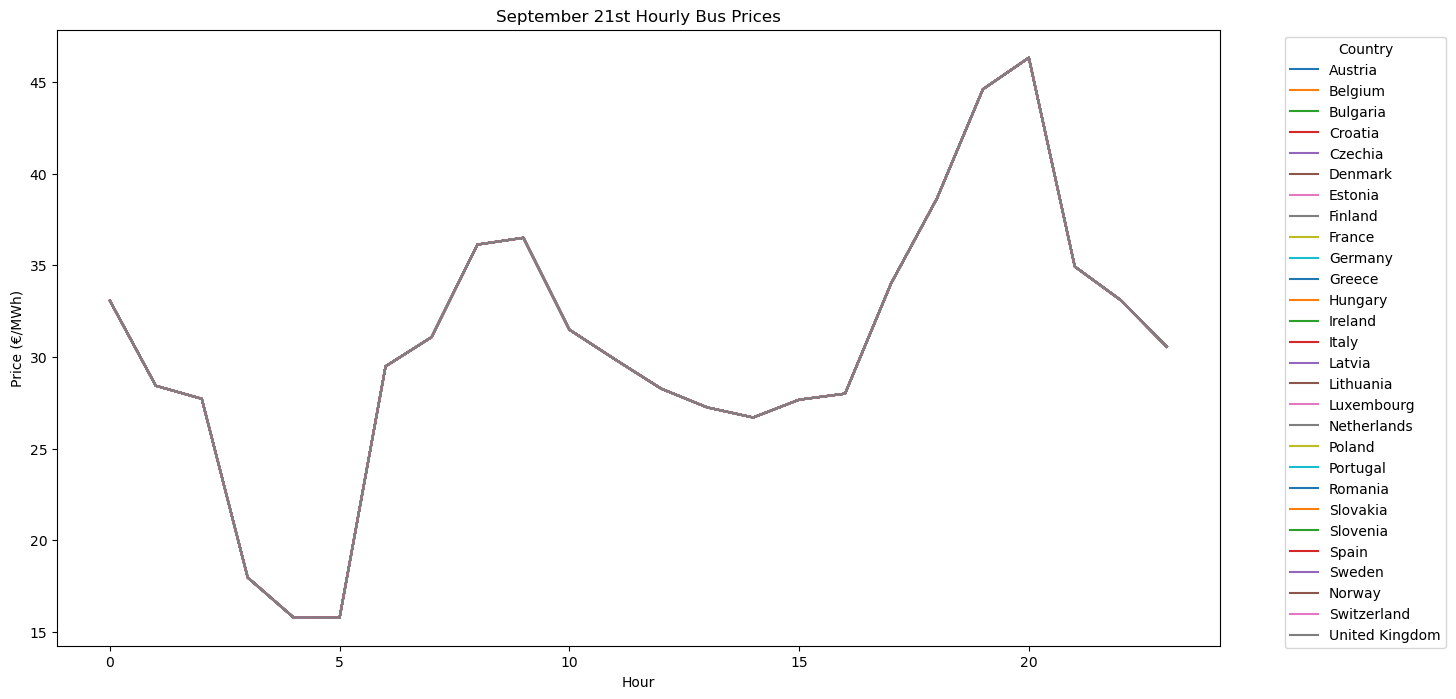

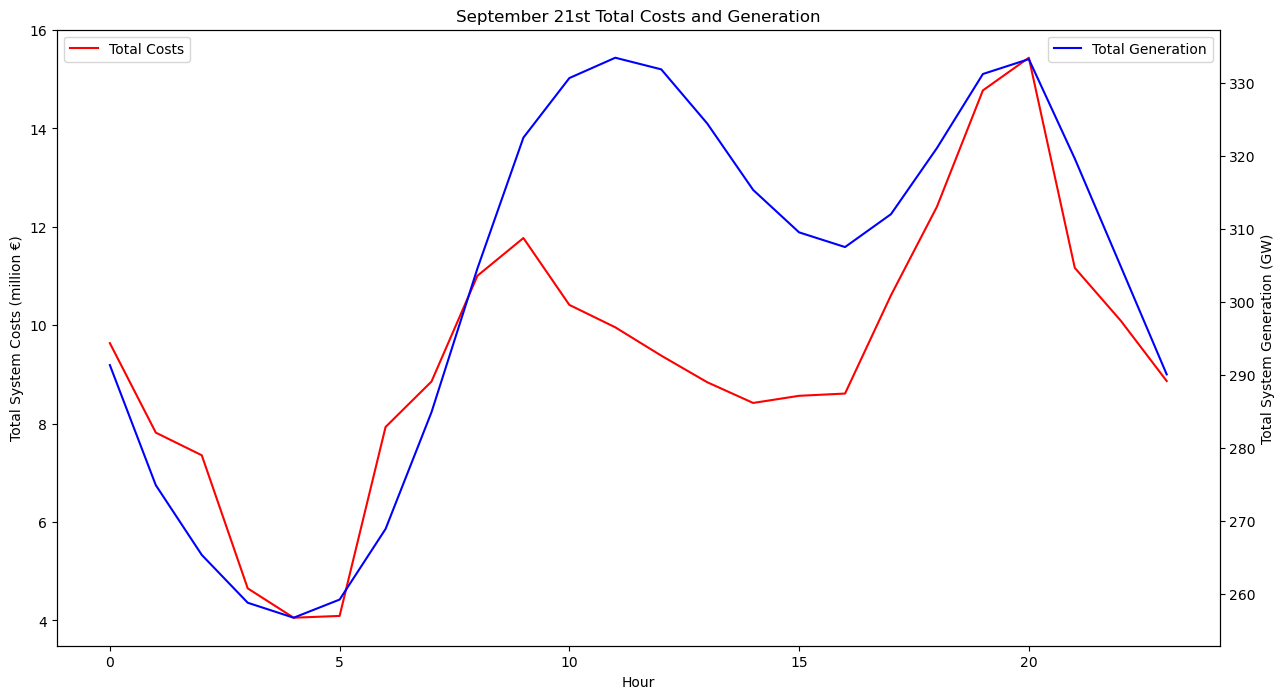

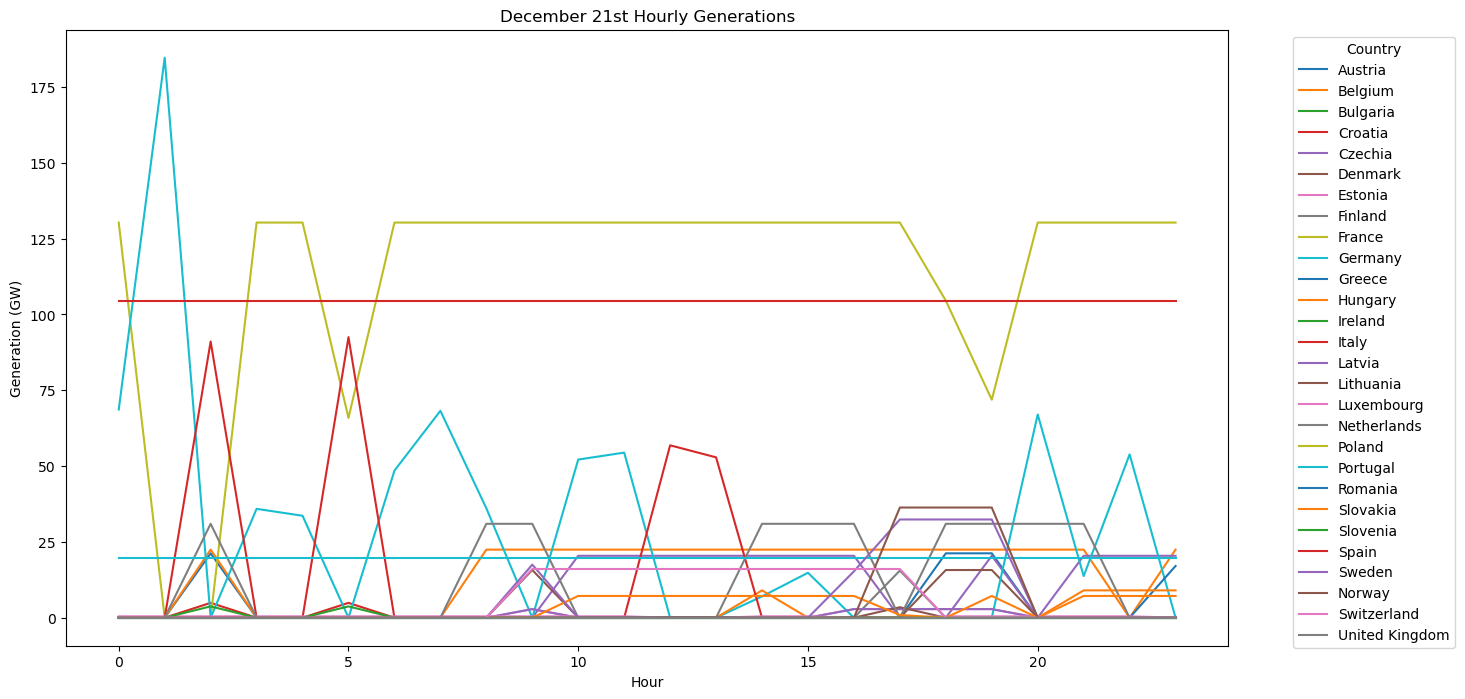

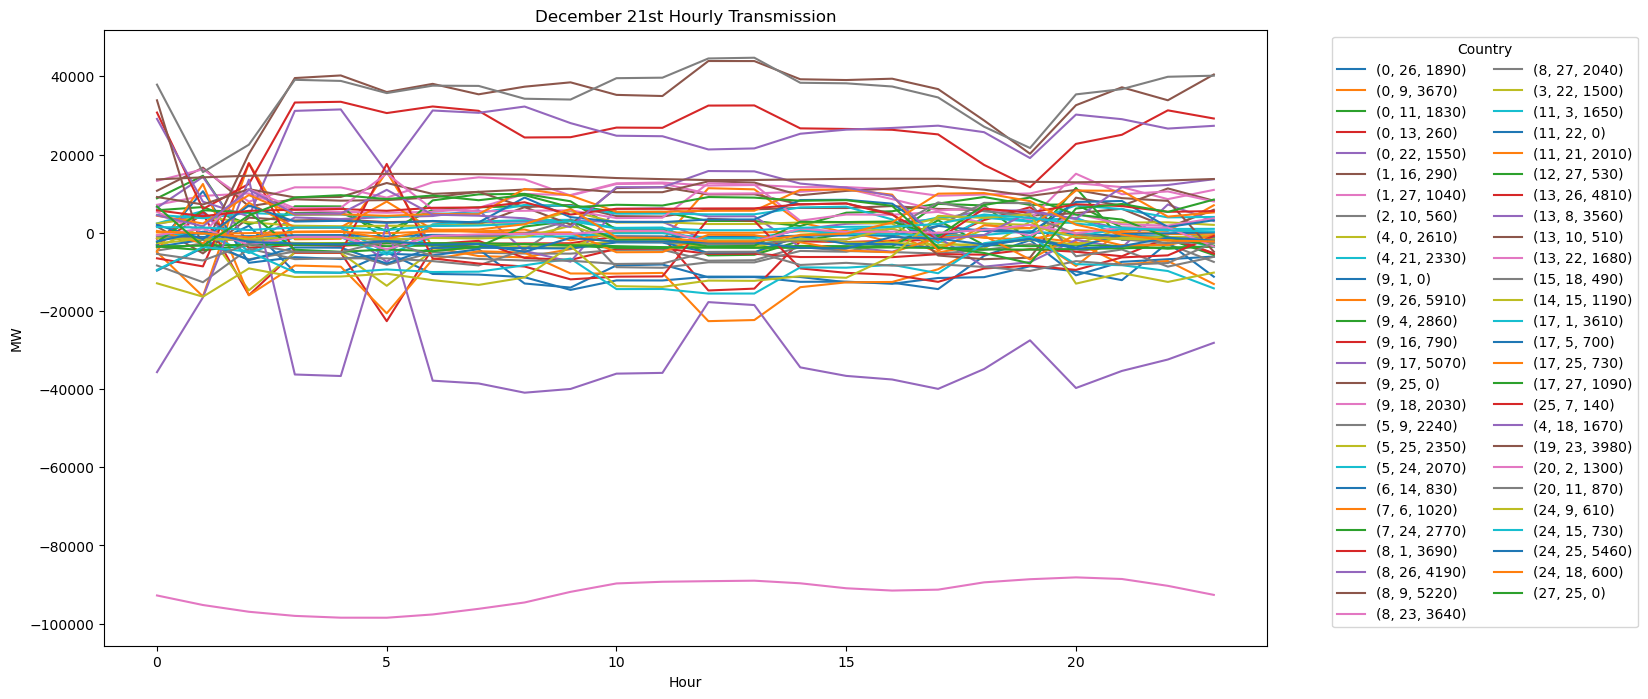

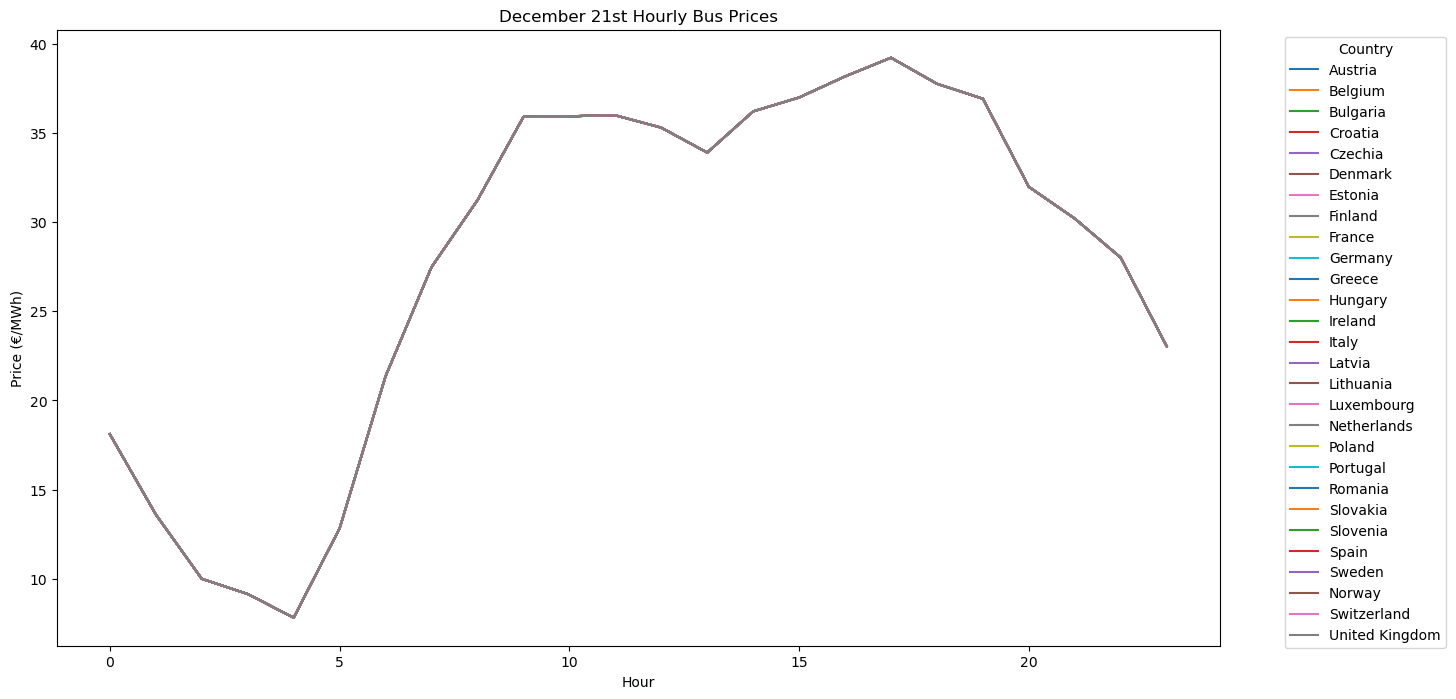

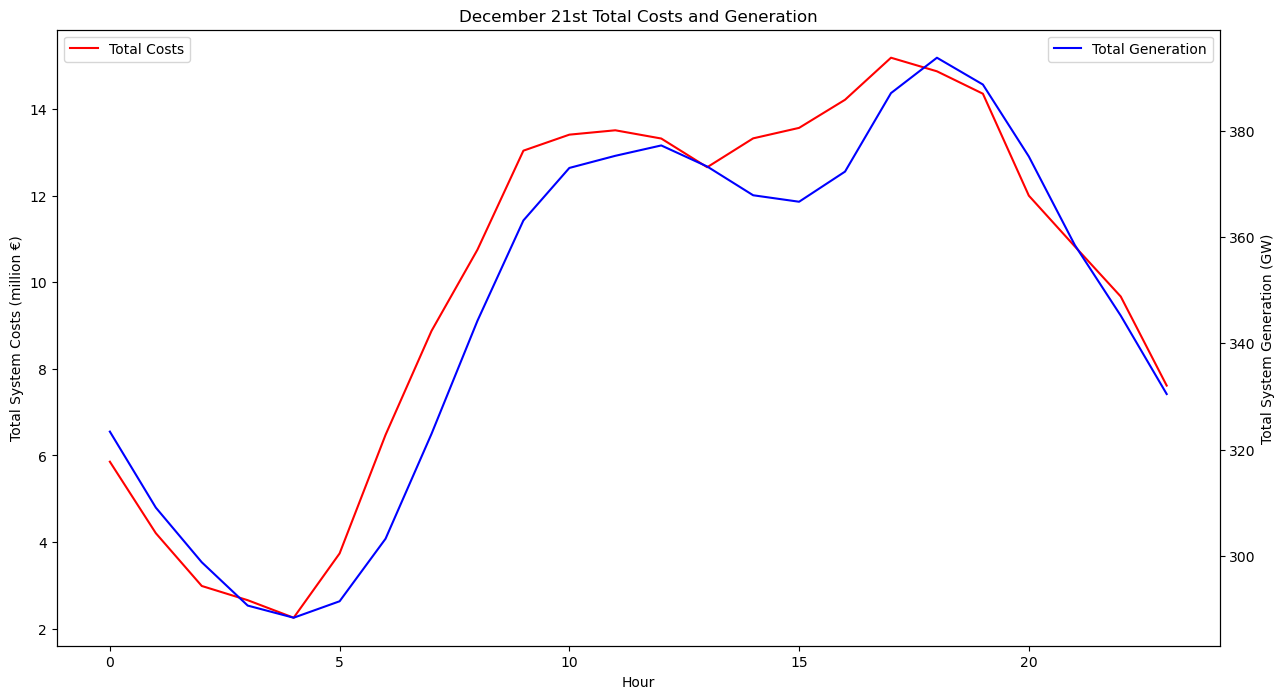

In [11]:
solve_and_plot_day(mar21data, gendata, 'March 21st', scenario1=True)
solve_and_plot_day(jun21data, gendata, 'June 21st', scenario1=True)
solve_and_plot_day(sep21data, gendata, 'September 21st', scenario1=True)
solve_and_plot_day(dec21data, gendata, 'December 21st', scenario1=True)

<Figure size 1500x800 with 0 Axes>

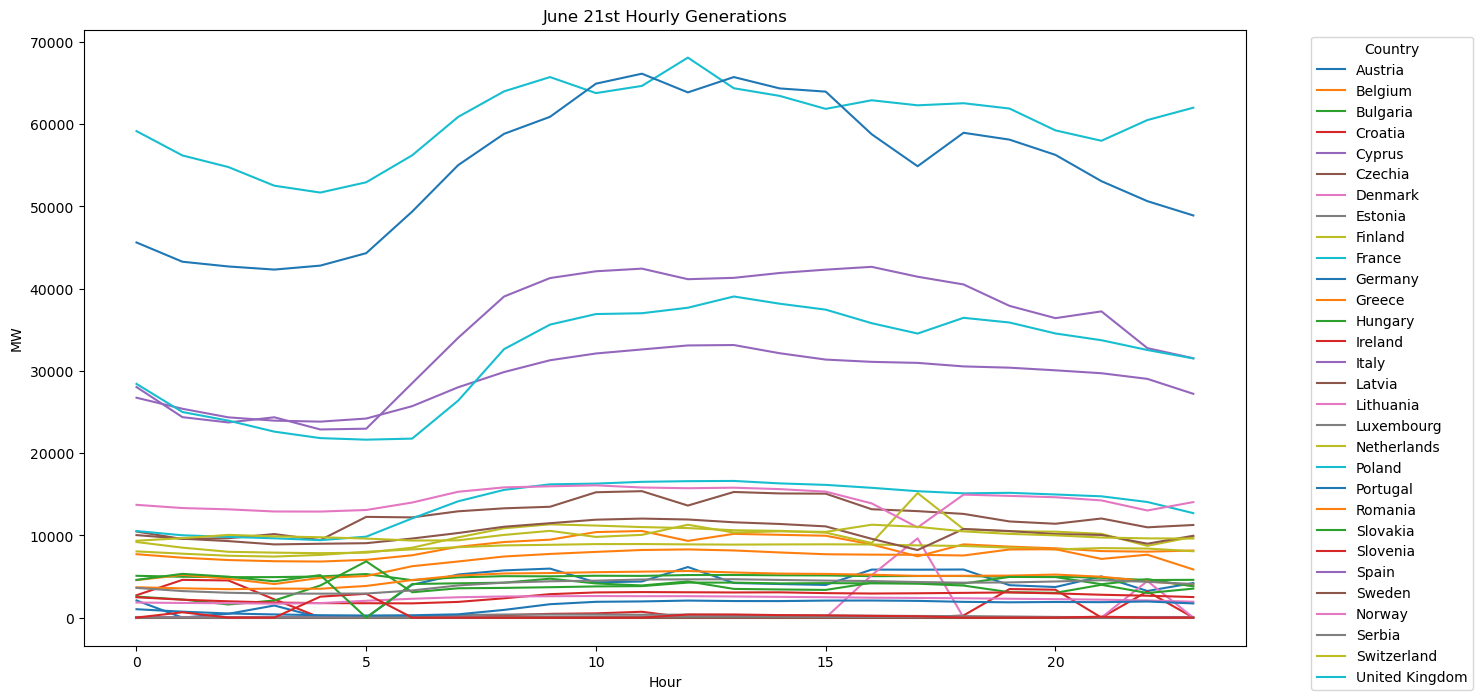

In [22]:
converted_generation = [[float(value) for value in row] for row in jun21_hourly_generation]

jun21_df_gen = pd.DataFrame(converted_generation, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
jun21_df_gen.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('June 21st Hourly Generations')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

(0, 28, 1890)  (0, 10, 3670)  (0, 12, 1830)  (0, 14, 260)  (0, 23, 1550)  \
0         -1890.0        -1260.0         640.00         260.0         640.00   
1         -1890.0        -1260.0        -237.00         260.0        -237.00   
2         -1890.0        -1260.0          69.00         260.0          69.00   
3         -1890.0        -1260.0         640.00         260.0         640.00   
4         -1890.0        -1260.0         -90.00         260.0         -90.00   
5         -1890.0        -1260.0        -228.50         260.0        -228.50   
6         -1890.0        -1260.0        1407.00         260.0        1407.00   
7         -1890.0        -1260.0        1543.00         260.0        1543.00   
8         -1890.0        -1260.0        1550.00         260.0        1550.00   
9         -1890.0        -1260.0        1550.00         260.0        1550.00   
10        -1890.0        -2150.0        1550.00         260.0        1550.00   
11        -1890.0        -2150.0        1550.00         260.0        1550.00   
12        -1890.0        -1260.0        1550.00         260.0        1550.00   
13        -1890.0        -2150.0        1550.00         260.0        1550.00   
14        -1890.0        -2150.0        1550.00         260.0        1550.00   
15        -1890.0        -2150.0        1550.00         260.0        1550.00   
16        -1890.0        -1260.0        1550.00         260.0        1550.00   
17        -1890.0        -1260.0        1550.00         260.0        1550.00   
18        -1890.0        -1260.0        1550.00         260.0        1550.00   
19        -1890.0        -1260.0         740.00         260.0         740.00   
20        -1890.0        -1260.0         740.00         260.0         740.00   
21        -1890.0        -1260.0        1550.00         260.0        1550.00   
22        -1890.0        -1260.0         740.00         260.0         740.00   
23        -1890.0        -1260.0        1439.75         260.0        1439.75   

    (1, 17, 290)  (1, 29, 1040)  (2, 11, 560)  (5, 0, 2610)  (5, 22, 2330)  \
0          255.0            0.0        560.00        1720.0         350.00   
1          236.0            0.0        560.00        1720.0        -527.00   
2          232.0            0.0        560.00        1720.0        -221.00   
3          231.5            0.0        560.00        1720.0         350.00   
4          233.5            0.0        560.00        1720.0        -380.00   
5          244.5            0.0        560.00        1720.0        2178.25   
6          263.0            0.0       -560.00        1720.0        1117.00   
7          290.0            0.0       -560.00        1720.0        1253.00   
8          290.0            0.0       -560.00        1720.0        1260.00   
9          290.0            0.0       -560.00        1720.0        1260.00   
10         290.0            0.0       -560.00        2610.0        2150.00   
11         290.0            0.0       -560.00        2610.0        2150.00   
12         290.0            0.0       -560.00        1720.0        1260.00   
13         290.0            0.0       -560.00        2610.0        2150.00   
14         290.0            0.0       -560.00        2610.0        2150.00   
15         290.0            0.0       -560.00        2610.0        2150.00   
16         290.0            0.0       -560.00        1720.0        1260.00   
17         290.0            0.0       -560.00        1720.0        1260.00   
18         290.0            0.0       -560.00        1720.0        1260.00   
19         290.0            0.0       -560.00        1720.0         450.00   
20         290.0            0.0       -560.00        1720.0         450.00   
21         287.0            0.0       -560.00        1720.0        1260.00   
22         281.5            0.0       -560.00        1720.0         450.00   
23         269.5            0.0       -239.75        1720.0        1149.75   

    ...  (26, 8, 140)  (5, 19, 1670)  (20, 24, 3980)

<Figure size 1500x800 with 0 Axes>

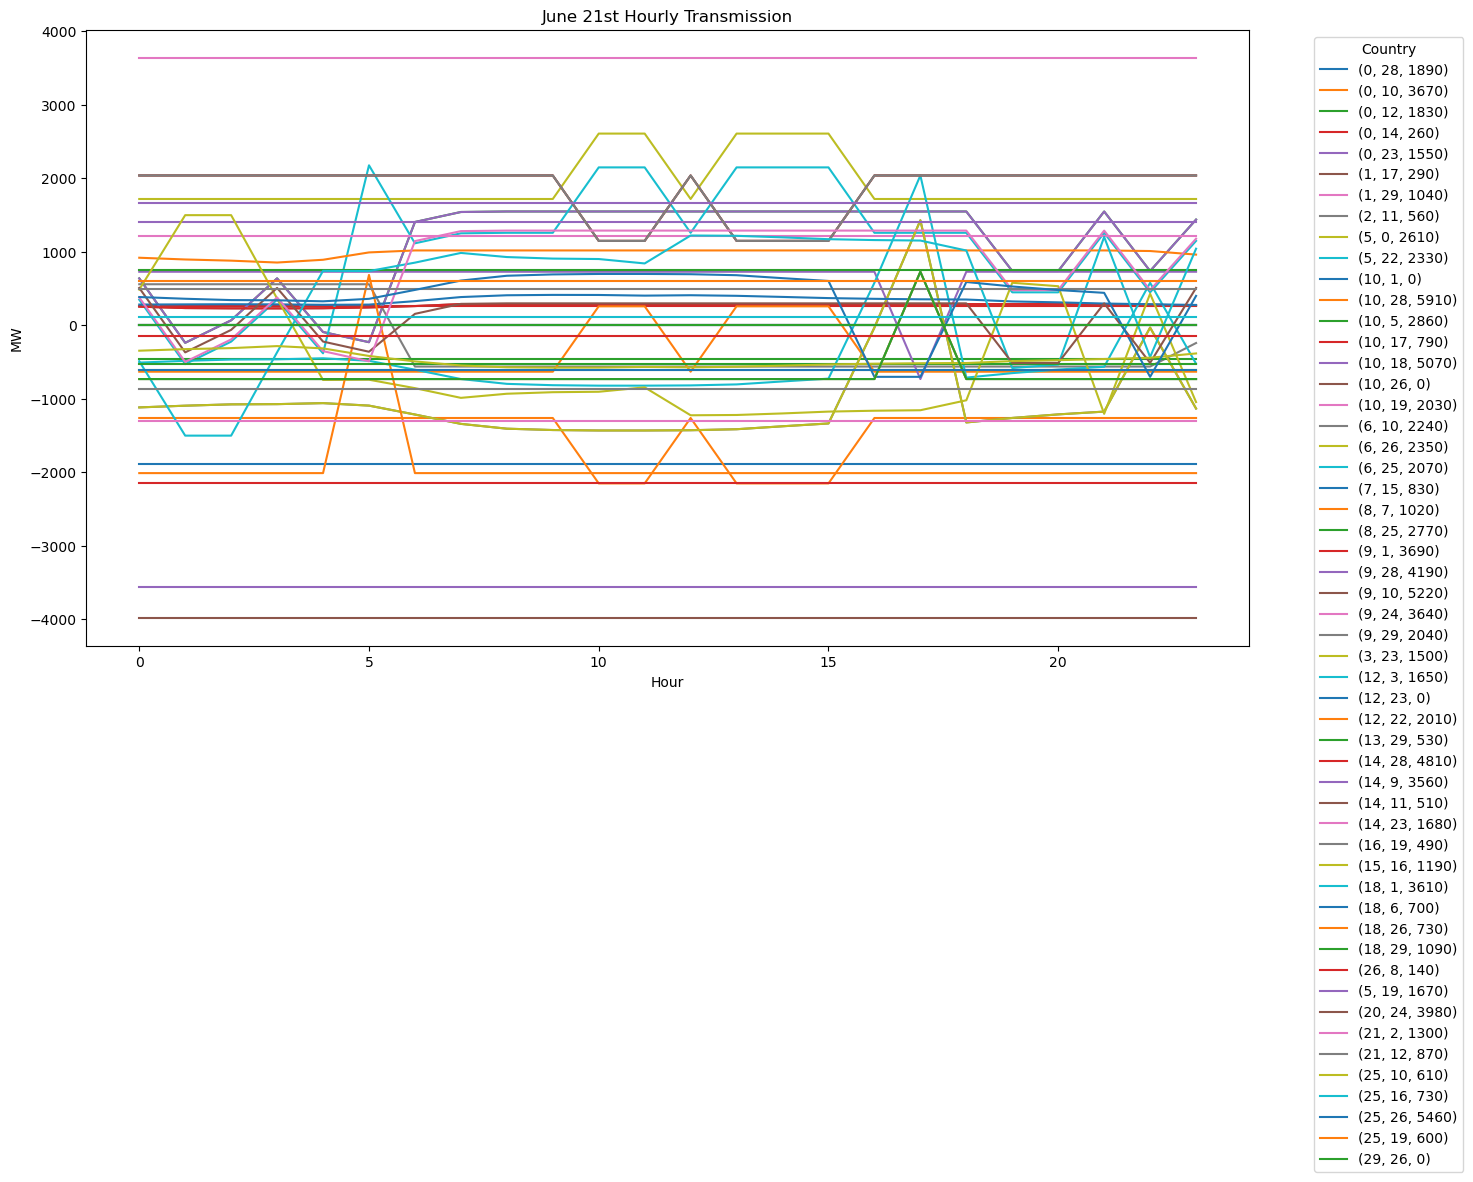

In [24]:
converted_transmision = [[float(value) for value in row] for row in jun21_hourly_transmission]

jun21_df_trans = pd.DataFrame(converted_transmision, columns = line_mapping)
display(jun21_df_trans)
# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
jun21_df_trans.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('June 21st Hourly Transmission')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

<Figure size 1500x800 with 0 Axes>

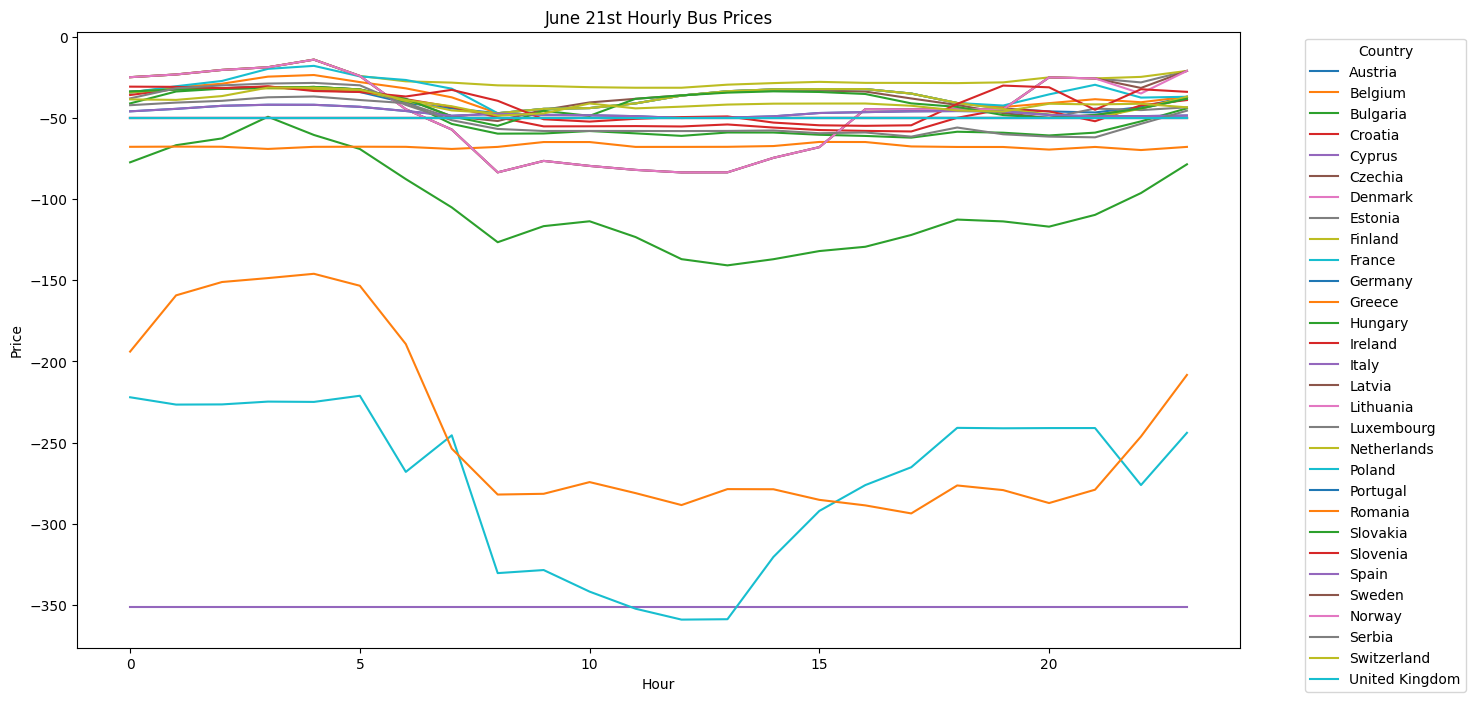

In [18]:
converted_prices = [[float(value) for value in row] for row in jun21_hourly_bus_prices]

jun21_df_prices = pd.DataFrame(converted_prices, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
jun21_df_prices.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('June 21st Hourly Bus Prices')
plt.xlabel('Hour')
plt.ylabel('Price')
#plt.ylim(-60, -20)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

In [19]:
# Initialize a list to store bus prices for each hour
dec21_hourly_bus_prices = []
dec21_hourly_generation = []
dec21_hourly_transmission = []

for time_step in range(24):
    # Construct the price and load arrays for this time step
    P_dec21 = np.array([dec21data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus", "Malta"] else 351.07 if country == "Cyprus" else 538 for country in countries])
    L_dec21 = np.array([dec21data[country]["Load"].iloc[time_step] if country not in ["Cyprus", "Malta"] else 351.07 if country == "Cyprus" else 538 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus", "Malta"] else 351.07 if country == "Cyprus" else 538 for country in countries])    
    
    dec21_total_cost, dec21_generation_amounts, dec21_bus_prices, dec21_transmission = optimize_power_system(L_dec21, P_dec21, G_data)

    # Store the bus prices for this hour
    dec21_hourly_bus_prices.append(dec21_bus_prices)
    dec21_hourly_generation.append(dec21_generation_amounts)
    dec21_hourly_transmission.append(dec21_transmission)


# Now, jun21_hourly_bus_prices is a list where each element is the bus prices for each hour

Total Generation: 328923.07
Total Demand: 328923.07
Total Generation: 314235.07
Total Demand: 314235.07
Total Generation: 303594.07
Total Demand: 303594.07
Total Generation: 295170.06999999995
Total Demand: 295170.07
Total Generation: 292828.07
Total Demand: 292828.07
Total Generation: 295972.07
Total Demand: 295972.07
Total Generation: 307934.07
Total Demand: 307934.07
Total Generation: 328013.07
Total Demand: 328013.07
Total Generation: 349687.07
Total Demand: 349687.07
Total Generation: 368826.07
Total Demand: 368826.07
Total Generation: 378770.07
Total Demand: 378770.07
Total Generation: 381020.07
Total Demand: 381020.07
Total Generation: 382891.07
Total Demand: 382891.07
Total Generation: 378887.07
Total Demand: 378887.07
Total Generation: 373396.07
Total Demand: 373396.07
Total Generation: 372218.07
Total Demand: 372218.07
Total Generation: 378130.07
Total Demand: 378130.07
Total Generation: 392961.07
Total Demand: 392961.07
Total Generation: 399582.07
Total Demand: 399582.07
Tot

<Figure size 1500x800 with 0 Axes>

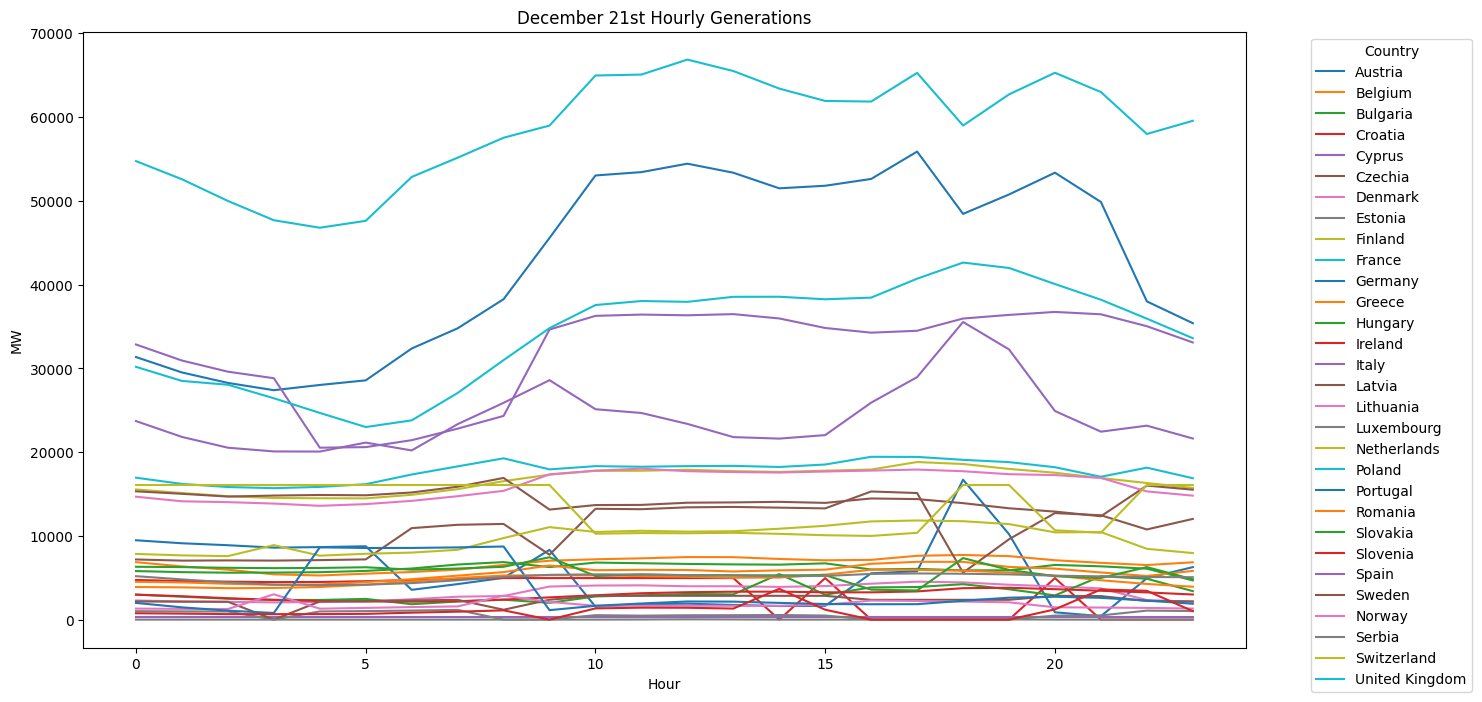

In [20]:
converted_generation = [[float(value) for value in row] for row in dec21_hourly_generation]

dec21_df_gen = pd.DataFrame(converted_generation, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
dec21_df_gen.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('December 21st Hourly Generations')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

<Figure size 1500x800 with 0 Axes>

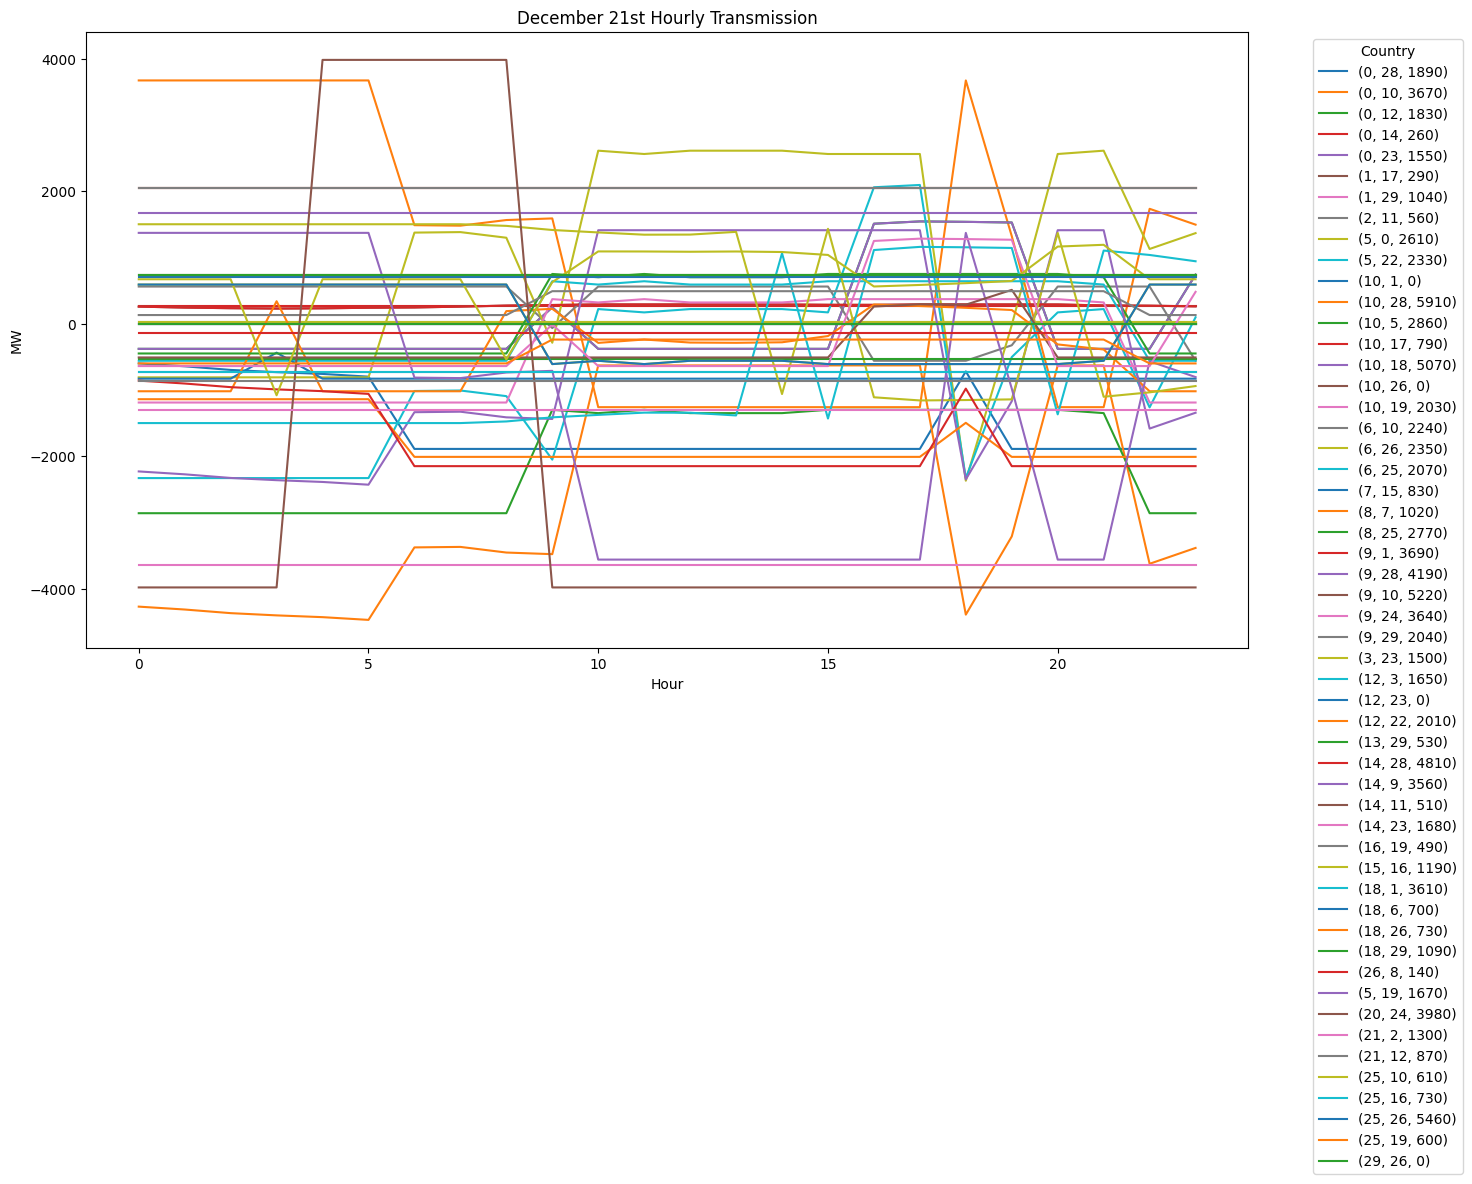

In [21]:
converted_transmision = [[float(value) for value in row] for row in dec21_hourly_transmission]

dec21_df_trans = pd.DataFrame(converted_transmision, columns = line_mapping)

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
dec21_df_trans.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('December 21st Hourly Transmission')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

<Figure size 1500x800 with 0 Axes>

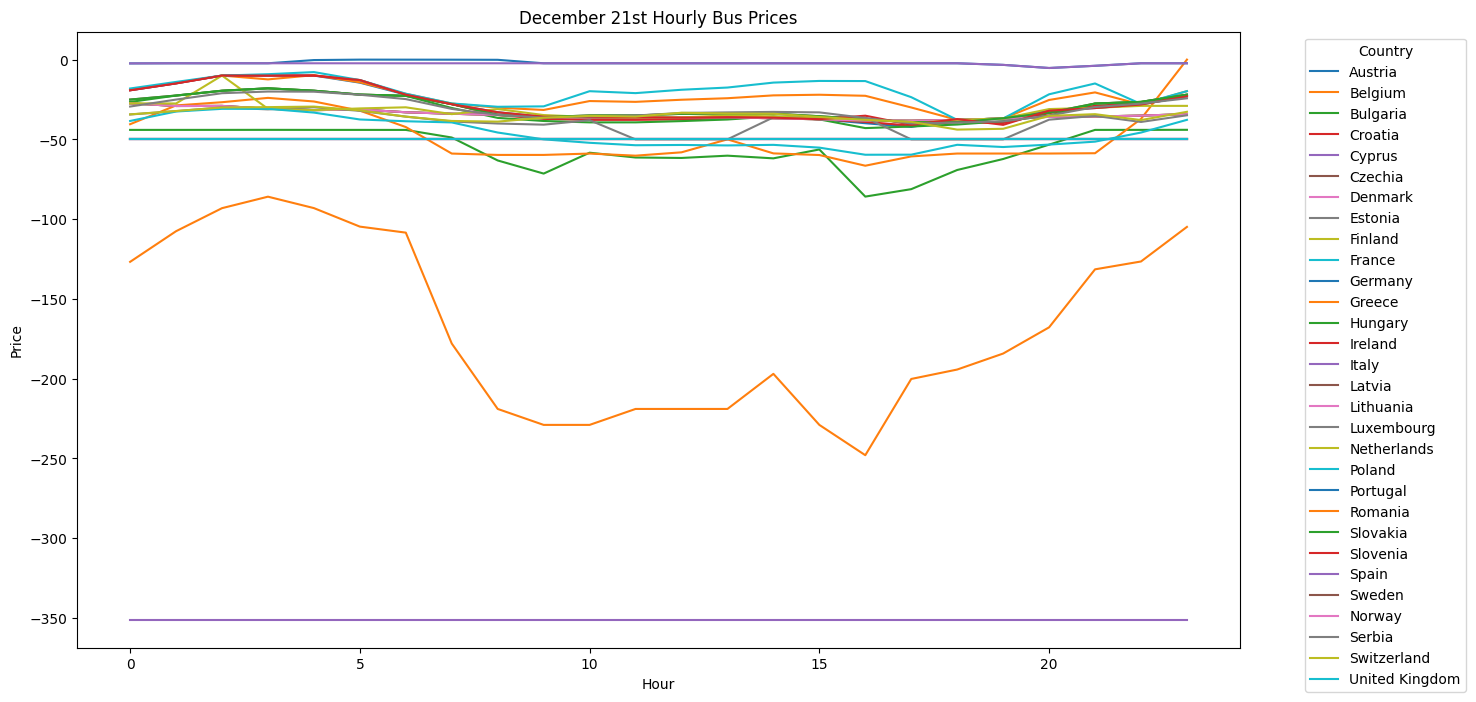

In [22]:
converted_prices = [[float(value) for value in row] for row in dec21_hourly_bus_prices]

dec21_df_prices = pd.DataFrame(converted_prices, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
dec21_df_prices.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('December 21st Hourly Bus Prices')
plt.xlabel('Hour')
plt.ylabel('Price')
#plt.ylim(-40, 1)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()